# MARL-eval Tools quickstart notebook
This notebook provides an easy introduction to the `marl-eval` repo by showing examples of how to use the different plotting and data processing tools.


### 1. Installing packages
We start by installing the necessary packages

In [1]:
#@title Install required packages. (Run Cell)

# Install required packages.
! pip install "git+https://github.com/instadeepai/marl-eval.git"

### 2. Import the necessary modules
Import the necessary modules that will be used for processing MARL experiment data and for producing plots

In [17]:
#@title Import required packages. (Run Cell)
import json

from marl_eval.plotting_tools.plotting import (
    aggregate_scores,
    performance_profiles,
    plot_single_task,
    probability_of_improvement,
    sample_efficiency_curves,
)

from marl_eval.utils.data_processing_utils import (
    create_matrices_for_rliable,
    data_process_pipeline,
)

### 3. Data processing and preparation

Import the json file containing raw experiment data and run the processing pipeline that will normalise any relevant data.

An example data json file is provided [here](https://github.com/instadeepai/marl-eval/blob/develop/examples/example_results.json) but should you wish to not use it, you can generate your own data using the [`generate_dummy_data.py`](https://github.com/instadeepai/marl-eval/blob/develop/examples/generate_dummy_data.py) script. 

In [18]:
# Import the data
with open("./example_results.json", "r") as data_file:
    raw_data = json.load(data_file)

# Choose the list of metrics to normalize
METRICS_TO_NORMALIZE = ["return"]

# Call data_process_pipeline to normalize the choosen metrics and to clean the data
processed_data = data_process_pipeline(
    raw_data=raw_data, metrics_to_normalize=METRICS_TO_NORMALIZE
)

Next we need to create two different dictionaries that will be used to create plots. To do this we will make use of the [`create_matrices_for_rliable`](https://github.com/instadeepai/marl-eval/blob/4856b06467872fd8b6f8a5db5fa7c9d7d55e2431/marl_eval/utils/data_processing_utils.py#L279) function. 
  
  **a)  metric_dictionary_return:**

  - The dictionary will have the names of all aggregated metrics as keys. Under each aggregated metric key there will be a 2D array corresponding to the mean of the normalised absolute metric values for each algorithm in a given experiment. 

  - These 2D arrays will have dimensions given as (number of runs x number of tasks). 

  **b)  final_metric_tensor_dictionary:**

  - This dictionary will, similarly, have keys corresponding to the aggregated experiment metrics. Under each aggregated metric key there will now be a 3D array corresponding to the mean normalised metric at each evaluation step. 

  - These 3D arrays will have dimensions given as (number of runs x number of tasks x number of logging steps).

The `create_matrices_for_rliable` function has 3 arguments which are:

  - data_dictionary: The dictionary of processed data
  
  - environment_name: Name of environment for which the arrays should be computed.

  - metrics_to_normalize: List of metric metric names that should be normalised.

In [19]:
environment_comparison_matrix, sample_effeciency_matrix = create_matrices_for_rliable(
    data_dictionary=processed_data,
    environment_name="env_1",
    metrics_to_normalize=METRICS_TO_NORMALIZE,
)

### 4. Use the `marl-eval` plotting tools

We can now use the generated dictionaries to produce relevant aggregated plots. For more information on how each plot may be interpreted please see the [rliable repo](https://github.com/google-research/rliable). 

**a) `performance_profiles`**
   - This function produces performance profile plots and has the following arguments: 
   
      - dictionary: The `environment_comparison_matrix` constructed from the absolute metric data. 
      - metric_name: Name of metric for which to produce plots.
      - metrics_to_normalize: List of metrics that have been normalised.

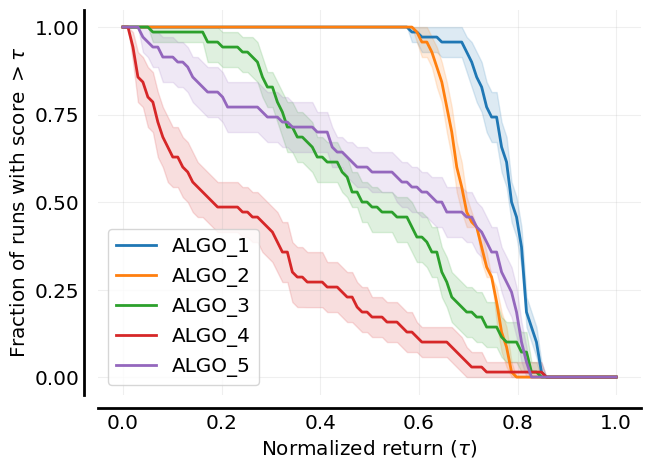

In [20]:
fig = performance_profiles(
    environment_comparison_matrix,
    metric_name="return",
    metrics_to_normalize=METRICS_TO_NORMALIZE,
)

**b) `aggregate_scores`**
   - This function produces plots of the median, inter-quartile mean, mean and optimality gap aggregated scores for each algorithm on a particular environment. Aside from the plots tabular data corresponding to each metric is also given in the terminal can can be saved in a `.csv` file and in LaTex format in a `.txt` file.
   
   - This function has to following arguments:
      - dictionary: The `environment_comparison_matrix` constructed from the absolute metric data. 
      - metric_name: Name of metric for which to produce plots.
      - metrics_to_normalize: List of metrics that have been normalised.
      - rounding_decimals: Amount of decimal places up to which the tabular result values should be rounded to.
      - tabular_results_file_path: Path where the tabular results should be stored.
      - save_tabular_as_latex: Whether tabular results should be stored in LaTex format as well.

The tabular results are stored in ./aggregated_score_return.csv and they are the following
                            ALGO_1             ALGO_2             ALGO_3  \
Median          0.78 [0.77, 0.79]  0.68 [0.67, 0.69]  0.53 [0.41, 0.62]   
IQM              0.79 [0.78, 0.8]    0.7 [0.7, 0.71]  0.51 [0.47, 0.54]   
Mean            0.78 [0.77, 0.79]    0.7 [0.7, 0.71]  0.51 [0.48, 0.53]   
Optimality Gap  0.22 [0.21, 0.23]    0.3 [0.29, 0.3]  0.49 [0.47, 0.52]   

                           ALGO_4             ALGO_5  
Median          0.27 [0.17, 0.35]  0.63 [0.55, 0.69]  
IQM             0.21 [0.17, 0.26]   0.6 [0.56, 0.64]  
Mean             0.26 [0.23, 0.3]  0.54 [0.51, 0.57]  
Optimality Gap   0.74 [0.7, 0.77]  0.46 [0.43, 0.49]  
The latex tabular results are stored in ./aggregated_score_return_latex.txt


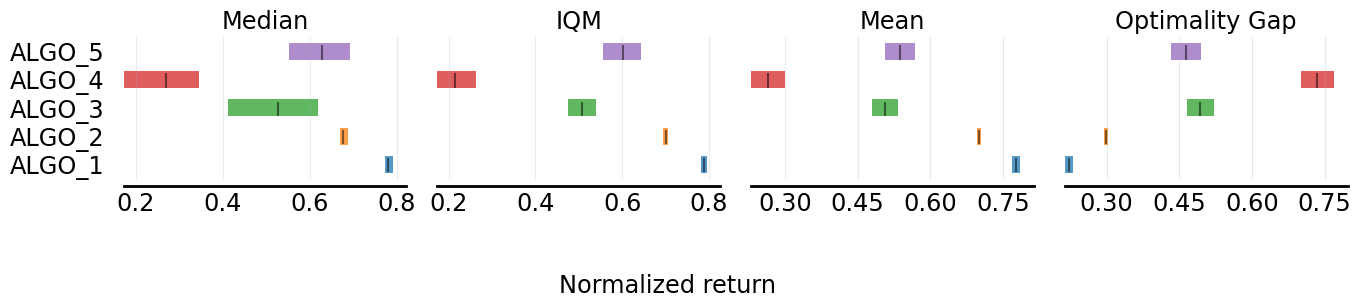

In [21]:
fig, _, _ = aggregate_scores(
    dictionary=environment_comparison_matrix,
    metric_name="return",
    metrics_to_normalize=METRICS_TO_NORMALIZE,
    save_tabular_as_latex=True,
)

**C) `probability_of_improvement`**
   - This function produces probability of improvement plots which may be interpreted as the probably that Algorithm X improves over Algorithm Y. 
   
   - The function has the following arguments:
      - dictionary: The `environment_comparison_matrix` constructed from the absolute metric data. 
      - metric_name: Name of metric for which to produce plots.
      - metrics_to_normalize: List of metrics that have been normalised.
      - algorithms_to_compare: A 2D list containing pairs of algorithms to be compared (e.g. `[["algo_1", "algo_2"], ["algo_1", "algo_3"], ["algo_2", "algo_3"]]`)

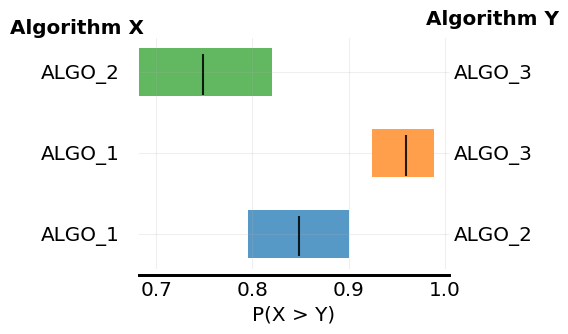

In [22]:
fig = probability_of_improvement(
    environment_comparison_matrix,
    metric_name="success_rate",
    metrics_to_normalize=METRICS_TO_NORMALIZE,
    algorithms_to_compare=[["algo_1", "algo_2"], ["algo_1", "algo_3"], ["algo_2", "algo_3"]],
)

**d) `sample_e_fficiency_curves`**
   - This function produces sample efficiency curve plots.
   
   - The function has the following arguments:
     - dictionary: The `sample_effeciency_matrix` constructed from the raw experiment metric data. 
     - metric_name: Name of metric for which to produce plots.
     - metrics_to_normalize: List of metrics that have been normalised.

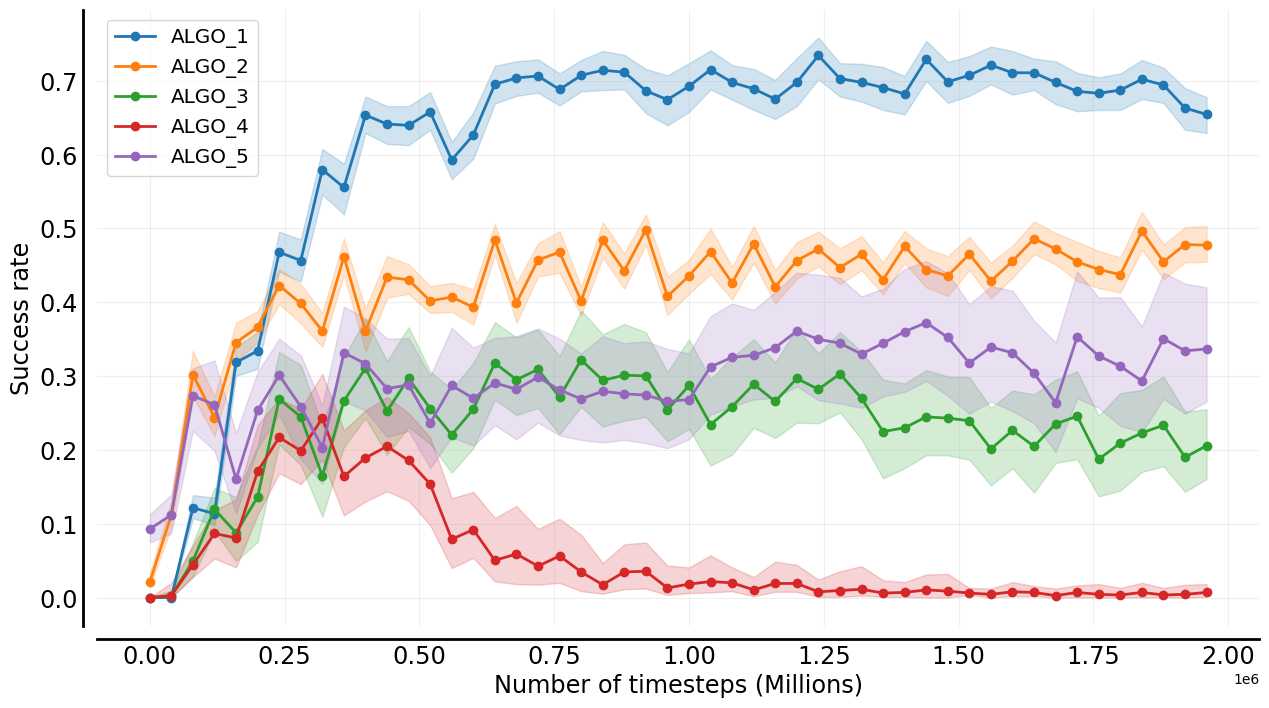

In [23]:
fig, _, _ = sample_efficiency_curves(
    dictionary=sample_effeciency_matrix,
    metric_name="success_rate",
    metrics_to_normalize=METRICS_TO_NORMALIZE,
)

**e) `plot_single_task`**
   - This function will aggregate and plot experiment data for all algorithms on a given task in an environment. Each plotting point is the mean over all independent experiment runs while the error is given by the 95% confidence interval. 
   
   - The function has the following arguments:
      - processed_data: The processed experiment data generated using the `data_process_pipeline`.
      - environment_name: The name of the environment for which to aggregate results. 
      - task_name: The name of the task for which to aggregate results. 
      - metric_name: Name of metric for which to produce plots.
      - metrics_to_normalize: List of metrics that have been normalised.

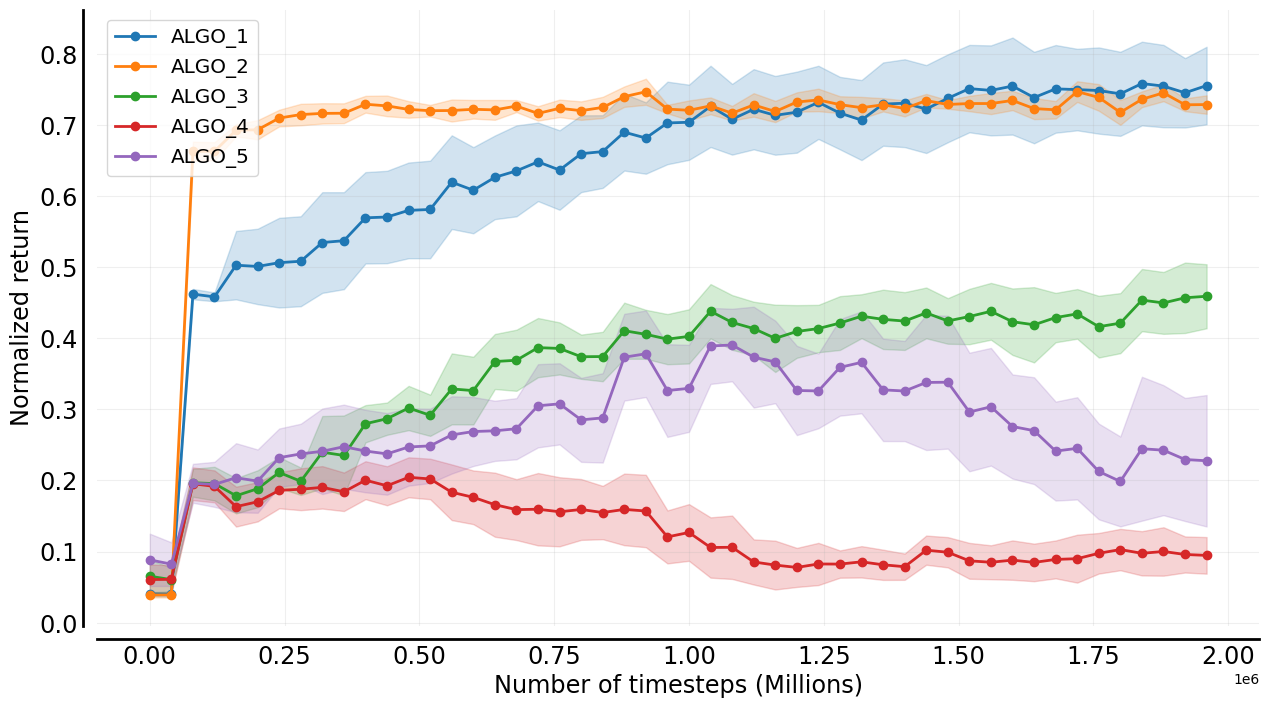

In [24]:
# Aggregate data over a single task
task = "task_1"
fig = plot_single_task(
    processed_data=processed_data,
    environment_name="env_1",
    task_name=task,
    metric_name="return",
    metrics_to_normalize=METRICS_TO_NORMALIZE,
)